In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir(f'/home/{user}/codes/MotionBERT')
import scipy.io

root_3dhp = f'/home/{user}/Datasets/HAAI/3DHP'
source = 'original' # 
root_original = os.path.join(root_3dhp, source)
train_folder = os.path.join(root_original, 'train')
test_folder = os.path.join(root_original, 'test')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def convert_intrinsic_from_mm_to_pixel(sensor_size, focal_length, pixel_aspect, center_offset, sensor_pixels_x, sensor_pixels_y):
    # Calculate pixel sizes
    pixel_size_x = sensor_size[0] / sensor_pixels_x
    pixel_size_y = sensor_size[1] * pixel_aspect / sensor_pixels_y

    # Calculate focal length in pixels
    fx = focal_length / pixel_size_x
    fy = focal_length / pixel_size_y

    # Calculate center offset in pixels
    center_offset_pixels_x = center_offset[0] / pixel_size_x
    center_offset_pixels_y = center_offset[1] / pixel_size_y

    cx, cy = sensor_pixels_x/2 + center_offset_pixels_x, sensor_pixels_y/2 + center_offset_pixels_y
    intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    return intrinsic

In [3]:
# Test video info
video_info = {'train': {}, 'test': {}}

for subject in os.listdir(test_folder):
    if 'TS' not in subject:
        continue
    video_info['test'][subject] = {}
    num_frame = len(os.listdir(f'/home/hrai/Datasets/HAAI/3DHP/original/test/{subject}/imageSequence'))
    img_list = natsorted(glob(f'/home/hrai/Datasets/HAAI/3DHP/original/test/{subject}/imageSequence/*.jpg'))
    img = cv2.imread(img_list[0])
    H, W, C = img.shape
    video_info['test'][subject]['num_frame'] = num_frame
    video_info['test'][subject]['W'] = W
    video_info['test'][subject]['H'] = H
print(video_info['test'])

# Test camera parameters
cam_params = {
    'test_cam_1_4': {
        'origin': np.array([3427.28, 1387.86, 309.42]),
        'up': np.array([-0.208215, 0.976233, 0.06014]),
        'right': np.array([0.000575281, 0.0616098, -0.9981]),
        'sensor_size': np.array([10, 10]), # in mm
        'focal_length': 7.32506, # in mm
        'pixel_aspect': 1.00044, # y / x
        'center_offset': np.array([-0.0322884, 0.0929296]) # in mm (positive values move right and down)
    },
    'test_cam_5_6': {
        'origin': np.array([-2104.3074, 1038.6707, -4596.6367]),
        'up': np.array([0.025272345, 0.995038509, 0.096227370]),
        'right': np.array([-0.939647257, -0.009210289, 0.342020929]),
        'sensor_size': np.array([10, 5.625]), # in mm
        'focal_length': 8.770747185, # in mm
        'pixel_aspect': 0.993236423, # 
        'center_offset': np.array([-0.104908645, 0.104899704]) # in mm (positive values move right and down)
    }
}

for key in cam_params.keys():
    up = cam_params[key]['up']
    right = cam_params[key]['right']
    forward = np.cross(right, up)
    R = np.column_stack((right, up, forward))
    print(R)
    #R = np.array([right, up, forward]).T # np.array([right, up, forward]).T #
    t = cam_params[key]['origin']/1000
    #t = -R@C
    C = -R.T@t
    cam_params[key]['R'] = R
    cam_params[key]['t'] = t
    cam_params[key]['C'] = C


{'TS2': {'num_frame': 6080, 'W': 2048, 'H': 2048}, 'TS5': {'num_frame': 320, 'W': 1920, 'H': 1080}, 'TS4': {'num_frame': 6009, 'W': 2048, 'H': 2048}, 'TS1': {'num_frame': 6151, 'W': 2048, 'H': 2048}, 'TS3': {'num_frame': 5839, 'W': 2048, 'H': 2048}, 'TS6': {'num_frame': 492, 'W': 1920, 'H': 1080}}
[[ 5.75281000e-04 -2.08215000e-01  9.78083371e-01]
 [ 6.16098000e-02  9.76233000e-01  2.07784794e-01]
 [-9.98100000e-01  6.01400000e-02  1.33896928e-02]]
[[-0.93964726  0.02527235 -0.34121028]
 [-0.00921029  0.99503851  0.09906346]
 [ 0.34202093  0.09622737 -0.93475244]]


### Testset

In [204]:
cam_dict = {}
for subject in ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']:
    if subject in ['TS1', 'TS2', 'TS3', 'TS4']: key = 'test_cam_1_4' 
    elif subject in ['TS5', 'TS6']: key = 'test_cam_5_6'
    
    R = cam_params[key]['R']
    t = cam_params[key]['t']
    C = cam_params[key]['C']
    W = video_info['test'][subject]['W']
    H = video_info['test'][subject]['H']
    num_frames = video_info['test'][subject]['num_frame']
    
    extrinsic = np.hstack((R, t.reshape(-1, 1)))
    intrinsic = convert_intrinsic_from_mm_to_pixel(cam_params[key]['sensor_size'], 
                                                   cam_params[key]['focal_length'], 
                                                   cam_params[key]['pixel_aspect'], 
                                                   cam_params[key]['center_offset'], 
                                                   W, 
                                                   H)
    
    cam_param = {'R': R, 
                 't': t, 
                 'C': C, 
                 'intrinsic': intrinsic, 
                 'extrinsic': extrinsic, 
                 'num_frames': num_frames, 
                 'W': W, 
                 'H': H} 
    
    cam_dict[subject] = cam_param

savepkl(cam_dict, f'/home/{user}/codes/MotionBERT/custom_codes/Dataset_generation/3dhp/3dhp_test_cam_params.pkl')

In [205]:
cam_dict = readpkl(f'/home/{user}/codes/MotionBERT/custom_codes/Dataset_generation/3dhp/3dhp_test_cam_params.pkl')

In [206]:
data_dict, cam_params = load_3dhp_original('test')

TS1 (6151, 17, 2) (6151, 17, 3) (6151,)
TS2 (6080, 17, 2) (6080, 17, 3) (6080,)
TS3 (5838, 17, 2) (5838, 17, 3) (5838,)
TS4 (6007, 17, 2) (6007, 17, 3) (6007,)
TS5 (320, 17, 2) (320, 17, 3) (320,)
TS6 (492, 17, 2) (492, 17, 3) (492,)


In [207]:
data_dict['TS4'].keys()

dict_keys(['annot2', 'annot3', 'valid_frame'])

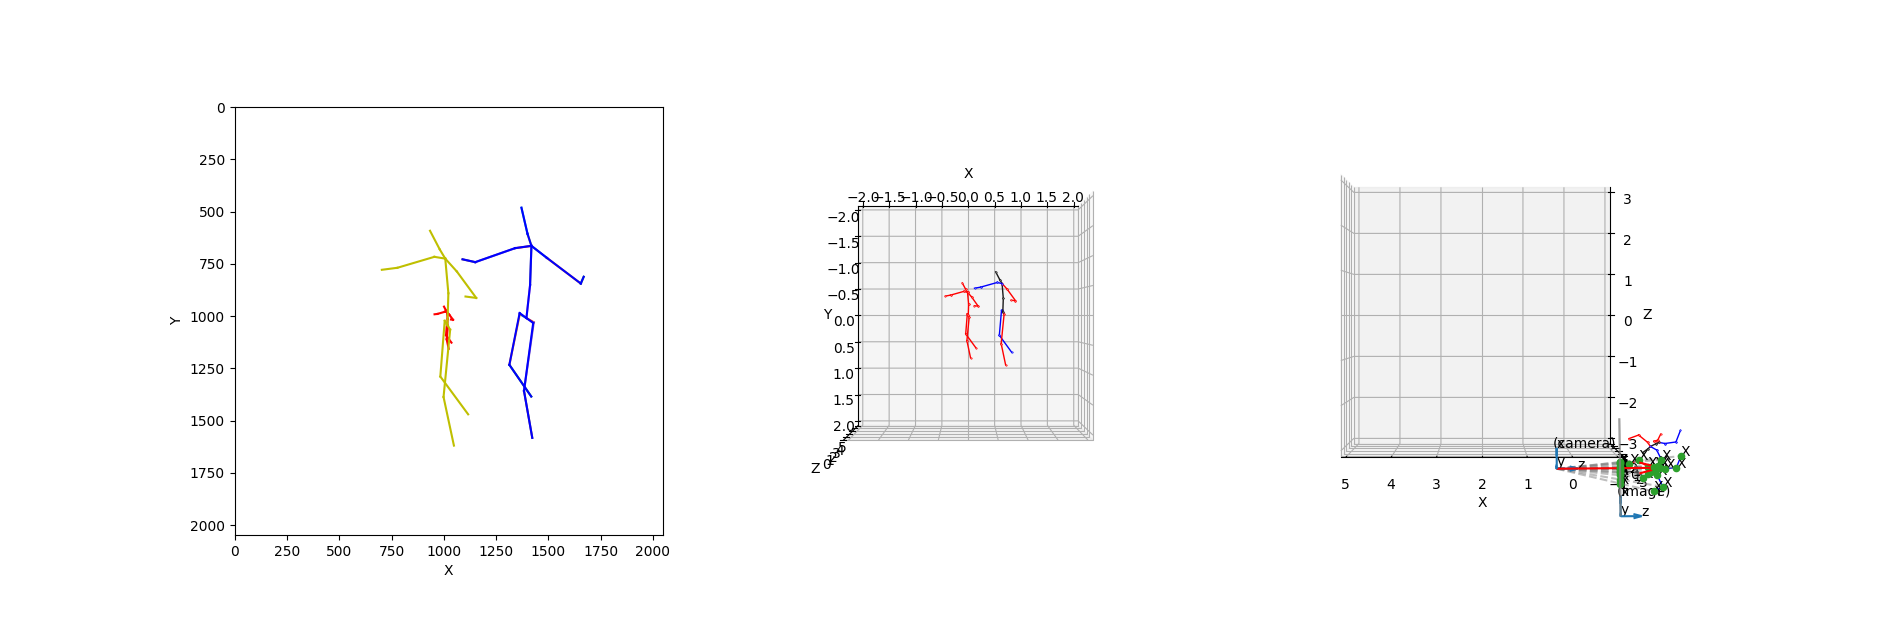

In [210]:
subject = 'TS4'
C = cam_params[subject]['C']
R = cam_params[subject]['R']
t = cam_params[subject]['t']
intrinsic = cam_params[subject]['intrinsic']
extrinsic = cam_params[subject]['extrinsic']
H, W = cam_params[subject]['H'], cam_params[subject]['W']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]

camera = Camera(origin=C, 
                calib_mat=intrinsic, 
                cam_default_R=R, 
                IMAGE_HEIGHT=H, 
                IMAGE_WIDTH=W,
                cam_name='camera')

fx = intrinsic[0, 0]
fy = intrinsic[1, 1]
cx = intrinsic[0, 2]
cy = intrinsic[1, 2]

frame_num = 5500
img_2d_gt = data_dict[subject]['annot2']
cam_3d = data_dict[subject]['annot3']/1000
cam_3d_hat = get_rootrel_pose(cam_3d)
world_3d = np.einsum('ij,jkl->ikl', R.T, (cam_3d - t).T).T
world_3d_from_canonical_3d, vector_cam_forward = get_canonical_3d(world_3d, cam_3d, C, R, return_vector_cam_forward=True, canonical_type='same_z')
#world_to_camera()
cam_3d_from_canonical_3d = np.einsum('ij,jkl->ikl', R, (world_3d_from_canonical_3d-C).T).T
original_depth = cam_3d_from_canonical_3d[:, 0:1, 2:3].copy() # (F, J, 1)
cam_3d_from_canonical_3d[..., 2] += 10
scale_ratio = (10 + original_depth) / original_depth
img_2d_from_canonical_3d = _weak_project(cam_3d_from_canonical_3d, fx, fy, cx, cy)
temp = img_2d_from_canonical_3d.copy()
temp -= img_2d_from_canonical_3d[:, 0:1, :]
temp *= scale_ratio[frame_num]
temp += img_2d_from_canonical_3d[:, 0:1, :]
img_2d = _weak_project(cam_3d, fx, fy, cx, cy)

# box = infer_box(cam_3d*1000, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
# img_2d, img_3d = camera_to_image_frame(cam_3d*1000, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
# img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

# # 2.5d factor
# pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용

fig = plt.figure(1)
fig.clear()
ax = axes_2d(fig, loc=131, H=H, W=W)
ax_cam = axes_3d(fig, loc=132, view=(-90,-90), xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 5))
ax_world = axes_3d(fig, loc=133, view=(0, 90), xlim=(-1, 5), zlim=(-3, 3), ylim=(-2, 3))

camera.update_pose_projection([world_3d_from_canonical_3d[frame_num]])


draw_2d_pose(ax, img_2d[frame_num], H=H, W=W)
draw_2d_pose(ax, img_2d_gt[frame_num], H=H, W=W, color='b')  
draw_2d_pose(ax, img_2d_from_canonical_3d[frame_num], H=H, W=W, color='r')
draw_2d_pose(ax, temp[frame_num], H=H, W=W, color='y')
#draw_3d_pose(ax_cam, cam_3d)
draw_3d_pose(ax_cam, cam_3d[frame_num])
draw_3d_pose(ax_cam, cam_3d_from_canonical_3d[frame_num], color='r')
#draw_3d_pose(ax_cam, img_3d_hat*pred_lambda, color='r')

draw_3d_pose(ax_world, world_3d[frame_num])
draw_3d_pose(ax_world, world_3d_from_canonical_3d[frame_num])
plt.sca(ax_world)
camera.cam_frame.draw3d()
camera.image_frame.draw3d()
camera.image_plane.draw3d()
for i in range(len(camera.Gs)):
    camera.Gs[i].draw3d(camera.pies[i], C=camera.C)
draw3d_arrow(arrow_location=camera.origin, 
                arrow_vector=vector_cam_forward[frame_num], 
                head_length=0.5,
                color='r',
                ax=ax_world)
plt.show()

In [198]:
scale_ratio.shape

(6007, 17, 1)

In [58]:
h36m_data = readpkl('/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt.pkl')

In [70]:
frame_num = 500
img_2d = h36m_data['test']['joint_2d'][frame_num]
img_2d_norm = normalize_input(img_2d, 1000, 1000)
cam_3d = h36m_data['test']['cam_3d'][frame_num]
cam_3d_hat = get_rootrel_pose(cam_3d)
cam_param = h36m_data['test']['cam_param'][frame_num]

In [63]:
cam_param

array({'intrinsic': array([[1.14551134e+03, 0.00000000e+00, 5.14968197e+02],
       [0.00000000e+00, 1.14477393e+03, 5.01882019e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 'extrinsic': array([[ 0.91546071, -0.39734607,  0.0636223 , -0.06927126],
       [-0.04940628, -0.26789168, -0.96218141,  0.42218434],
       [ 0.39936288,  0.87769594, -0.2648757 ,  4.45789337]])},
      dtype=object)

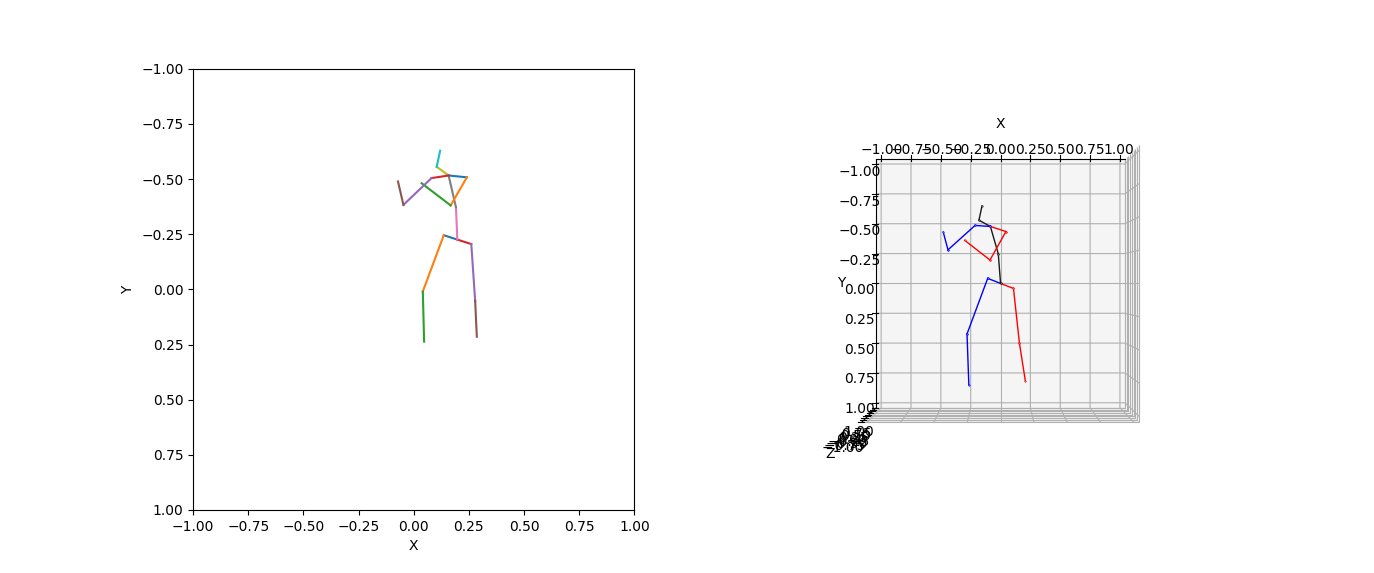

In [71]:


fig = plt.figure(2)
fig.clear()
ax = axes_2d(fig, loc=121, normalize=True)
ax_cam = axes_3d(fig, loc=122, view=(-90,-90), xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))
draw_2d_pose(ax, img_2d_norm, normalize=True)
draw_3d_pose(ax_cam, cam_3d_hat)
plt.show()

### Trainset

In [6]:
# train camera parameters
f = open(os.path.join(train_folder, 'S1', 'Seq1', 'camera.calibration'), 'r')
lines = f.readlines()
name = -1
cam_dict = {}


for line in lines:
    item = line.strip().split(' ')
    item_type = item[0]
    #print(item)
    if item_type == 'name':
        name = f'cam{item[-1]}'
        cam_dict[name] = {}
    elif item_type == 'intrinsic':
        fx = float(item[3])
        cx = float(item[5])
        fy = float(item[8])
        cy = float(item[9])
        intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        cam_dict[name]['intrinsic'] = intrinsic
    elif item_type == 'extrinsic':
        R = np.array([[float(item[3]), float(item[4]), float(item[5])], [float(item[7]), float(item[8]), float(item[9]),], [float(item[11]), float(item[12]), float(item[13])]])
        t = np.array([float(item[6]), float(item[10]), float(item[14])])/1000
        C = -R.T@t
        #print(R.shape, t.shape)
        cam_dict[name]['R'] = R
        cam_dict[name]['t'] = t
        cam_dict[name]['C'] = C
    elif item_type == 'size':
        cam_dict[name]['W'] = float(item[-2])
        cam_dict[name]['H'] = float(item[-1])
        
savepkl(cam_dict, f'/home/{user}/codes/MotionBERT/custom_codes/Dataset_generation/3dhp/3dhp_train_cam_params.pkl')